In [22]:
import json
import cv2
from matplotlib import pyplot as plt
import os
import pandas as pd

with open("../config.json", "r") as f:
    config = json.load(f)

In [23]:
train_csv = pd.read_csv(config["TRAIN_METADATA"])

/tmp/ipykernel_5105/550750344.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_csv = pd.read_csv(config["TRAIN_METADATA"])


In [24]:
train_csv.shape

(401059, 55)

In [25]:
train_csv.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


(153, 153, 3)


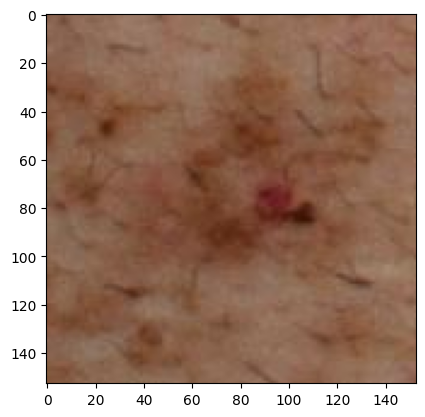

In [14]:
image_file_name = os.listdir(config["TRAIN_IMAGES_PATH"])[8]

image = cv2.imread(os.path.join(config["TRAIN_IMAGES_PATH"], image_file_name), cv2.IMREAD_COLOR)[:,:,::-1]
plt.imshow(image)
print(image.shape)